In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from src.utils.logger import get_logger
from src.utils.exceptions import CustomException
from src.utils.config_loader import config
from pathlib import Path

logger = get_logger(f"{__name__}.log")
logger.info("for fraud notebook started")


INFO - for fraud notebook started


Log file will be created at: /home/ermias/Desktop/fraud_task/Improved_detection_of_fraud_cases_for_e-commerce_and_bank_transactions/fraud-detection/logs/__main__.log


In [12]:
import os
os.getcwd()
root_path = '/home/ermias/Desktop/fraud_task/Improved_detection_of_fraud_cases_for_e-commerce_and_bank_transactions/fraud-detection/notebooks'

In [13]:
fraud_path = config.load('data.yaml')['fraud_data_csv']['path']
fraud_path


'data/raw/Fraud_Data.csv'

In [18]:
ip_path = config.load('data.yaml')['ip_to_country_csv']['path']
ip_path

'data/raw/IpAddress_to_Country.csv'

In [14]:


root_path = os.getcwd()  
data_path = os.path.join(root_path, "..", fraud_path)

df_fraud = pd.read_csv(data_path)

df_fraud.shape

(151112, 11)

In [19]:
data_path = os.path.join(root_path, "..", ip_path)

df_ip = pd.read_csv(data_path)

df_ip.shape

(138846, 3)

In [20]:
df_fraud.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [21]:

df_fraud['signup_time'] = pd.to_datetime(df['signup_time'], errors='coerce')
df_fraud['purchase_time'] = pd.to_datetime(df['purchase_time'], errors='coerce')


In [22]:
df_fraud.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [23]:
df_fraud.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [24]:
df_ip.isna().sum()

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [25]:
df_fraud.duplicated().sum()

np.int64(0)

In [26]:
df_ip.duplicated().sum()

np.int64(0)

/tmp/ipykernel_32941/4094640133.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')


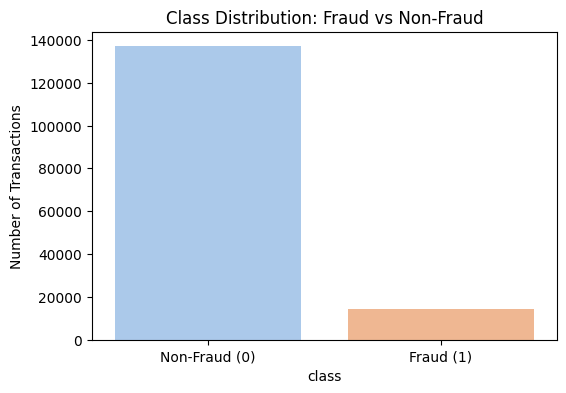

Fraud percentage: 9.3646%


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each class
class_counts = df_fraud['class'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='pastel')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.ylabel('Number of Transactions')
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.show()

# Optional: percentage
fraud_pct = 100 * class_counts[1] / class_counts.sum()
print(f"Fraud percentage: {fraud_pct:.4f}%")


In [34]:
# Check for exact duplicates
dup_mask = df.duplicated(keep=False)
num_duplicates = dup_mask.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Optionally, view duplicates
df_dups = df[dup_mask]
df_dups.head(10)

# Drop duplicates if desired
df = df.drop_duplicates()


Number of duplicate rows: 0


In [36]:
df_ip.columns


Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')

In [37]:
df_fraud.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [ ]:
def convert_ip_to_int(ip_str):
    """Convert IP address string to integer"""
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return 0

def merge_with_ip_country(df_fraud, df_ip):
    """Merge fraud data with country mapping using IP range lookup"""
    print("Merging with IP country data...")
    
    # Convert IP addresses to integers
    print("Converting IP addresses to integers...")
    df_fraud['ip_int'] = df_fraud['ip_address'].apply(convert_ip_to_int)
    
    # Prepare IP country data
    ip_df_clean = df_ip.copy()
    ip_df_clean['lower_int'] = ip_df_clean['lower_bound_ip_address'].apply(convert_ip_to_int)
    ip_df_clean['upper_int'] = ip_df_clean['upper_bound_ip_address'].apply(convert_ip_to_int)
    
    print(f"IP addresses converted to integers")
    print(f"Unique countries in mapping: {ip_df_clean['country'].nunique()}")
    
    # Perform range-based lookup
    print("\nPerforming range-based lookup (this may take a moment)...")
    
    # Create a function to find country for each IP
    def find_country(ip_int):
        # Find the row where ip_int is between lower_int and upper_int
        match = ip_df_clean[
            (ip_df_clean['lower_int'] <= ip_int) & 
            (ip_df_clean['upper_int'] >= ip_int)
        ]
        if not match.empty:
            return match.iloc[0]['country']
        return 'Unknown'
    
    # Apply the lookup
    df_fraud['country'] = df_fraud['ip_int'].apply(find_country)
    
    # Clean up
    df_fraud.drop('ip_int', axis=1, inplace=True)
    
    # Analyze country distribution
    country_counts = df_fraud['country'].value_counts()
    print(f"\nTop 10 countries by transaction count:")
    print(country_counts.head(10))
    
    unknown_count = (df_fraud['country'] == 'Unknown').sum()
    print(f"\nTransactions with unknown country: {unknown_count} ({unknown_count/len(df_fraud)*100:.2f}%)")
    
    return df_fraud

# CORRECTED: Merge with country data
# Assuming you have:
# fraud_data_unique - the cleaned fraud data
# ip_country - the IP to country mapping data
fraud_data_with_country = merge_with_ip_country(fraud_data_unique, ip_country)

In [1]:
def get_country(ip, ip_df):
    # This filters the IP table where the user IP falls between lower and upper bounds
    # Note: This approach can be slow on large datasets. 
    # For 150k rows, it might take a few minutes.
    try:
        match = ip_df[(ip >= ip_df['lower_bound_ip_address']) & 
                      (ip <= ip_df['upper_bound_ip_address'])]
        if len(match) > 0:
            return match['country'].iloc[0]
        return "Unknown"
    except:
        return "Error"